In [1]:
from __future__ import division, print_function

# Third-party                                                                                                                           
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')                                                                                                          
#%matplotlib inline                                                                                                                     
from astropy.table import Table

# Third-party                                                                                                                           
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from scipy.special import logsumexp
from scipy.stats import truncnorm
import emcee


# Custom                                                                                                                                
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.util import rolling_window
from scipy.signal import argrelmin,argrelmax
from scipy.stats import scoreatpercentile
from scipy.integrate import quad
from matplotlib import cm
from tqdm import tqdm

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.mpl_style

from coordinates import (pal5_c, galcen_frame,
                         pal5_lead_frame, pal5_trail_frame)
import matplotlib as mpl


obs_oden = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/obs_RA.txt')
OD = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/OD_radec.txt')

from potential import get_bar_model
from potential import default_mw



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

#Comapre with and wiggle of sims and data.                                                                                              
##Read in simulation RA DEC                                                                                                             
# Plot width and wiggle for all.                                                                                                        

#### Added by SP to load sims ####                                                                                                      
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def ln_truncnorm(x, mu, sigma, clip_a, clip_b):
    a, b = (clip_a - mu) / sigma, (clip_b - mu) / sigma
    return truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)

# 1 gaussian:                                                                                                                           
param_names = ['mu_s', 'lnstd_s']

def lnprior(p):
    mu_s, lnstd_s = p

    lp = 0

    lp += ln_truncnorm(mu_s, 0, 1, -1, 1)
    lp += ln_truncnorm(lnstd_s, -0.5, 1, -2.5, 1.5)

    return lp

def lnlike(p, phi2):
    mu_s, lnstd_s = p
    return lnnormal(phi2, mu_s, np.exp(lnstd_s))

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf

    ll = lnlike(p, phi2).sum()
    if not np.all(np.isfinite(ll)):
        return -np.inf

    return ll + lp

In [3]:


  ####Sims####   
sim_reg = np.loadtxt('Morphology/RADEC_MW14_q094.txt')
sim_reg_RA = sim_reg[:,0]
sim_reg_dec = sim_reg[:,1]

sim_chaos =  np.loadtxt('Morphology/RADEC_MW14_q050.txt')
sim_chaos_RA = sim_chaos[:,0]
sim_chaos_dec = sim_chaos[:,1]

sim_bar5e9 = np.loadtxt('Morphology/RADEC_RL5_M5e9_Om39.txt')
sim_bar5e9_RA = sim_bar5e9[:,0]
sim_bar5e9_dec = sim_bar5e9[:,1]

sim_bar1e10 = np.loadtxt('Morphology/RADEC_RL5_M1e10_Om40.txt')
sim_bar1e10_RA = sim_bar1e10[:,0]
sim_bar1e10_dec = sim_bar1e10[:,1]



In [4]:
#RA = np.array([sim_reg_RA,sim_chaos_RA,sim_bar5e9_RA,sim_bar1e10_RA])
#dec = np.array([sim_reg_dec,sim_chaos_dec,sim_bar5e9_dec,sim_bar1e10_dec])

In [5]:
#RA[0].shape

In [6]:

c = coord.SkyCoord(ra=sim_reg_RA *u.deg, dec=sim_reg_dec*u.deg)

c_l = c.transform_to(pal5_lead_frame)
c_t = c.transform_to(pal5_trail_frame)

Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,c_l.phi2.degree)).T
Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,c_t.phi2.degree)).T


phi1_bins = np.arange(0, 18+1e-3, 0.75)
phi2_bins = np.arange(-2, 2+1e-3, 0.1)

nwalkers = 64
nburn = 128
nsteps = 256


phi2_min = -2.
phi2_max = 2.

data = dict()
for name, X, _phi1_bins in zip(['lead', 'trail'],
                           [Xl, Xt],
                           [phi1_bins[:14], phi1_bins[:23]]):
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

    all_samplers = []
    Ns = []
    for i, l, r in zip(range(len(phi1_bins)-1),
                   _phi1_bins[:-1],
                   _phi1_bins[1:]):

        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        Ns.append((phi1_mask & phi2_mask).sum())

        H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
        phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
        mu = phi2_bin_c[H.argmax()]
        if np.abs(mu) > 1.:
            mu = 0.

  # for 1-component gaussian                                                                                                      
        p0 = (mu, np.log(0.1))

        p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

        sampler = emcee.EnsembleSampler(nwalkers, len(p0),
                                    log_prob_fn=lnprob,
                                    args=(binX[:, 1], ))

        pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
        pos = emcee.utils.sample_ball(np.median(pos, axis=0),
                                      [1e-3]*len(p0), nwalkers)
# sampler.reset()                                                                                                               
# _ = sampler.run_mcmc(pos, nburn, progress=True)                                                                               
        sampler.reset()
        pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)
        print()

        all_samplers.append(sampler)


    data[name] = dict()
    data[name]['X'] = X
    data[name]['samplers'] = all_samplers
    data[name]['phi1_bins'] = _phi1_bins
    data[name]['N'] = np.array(Ns)


flatchains_reg = dict()
for name in data:
    all_flatchains = []
    for sampler in data[name]['samplers']:
        all_flatchains.append(sampler.flatchain)

    all_flatchains = np.array(all_flatchains)

    flatchains_reg[name] = Table()
    for k, par in enumerate(param_names):
        if par.startswith('ln_'):
            flatchains_reg[name][par] = all_flatchains[..., k]
            flatchains_reg[name][par[3:]] = np.exp(all_flatchains[..., k])
        elif par.startswith('ln'):
            flatchains_reg[name][par] = all_flatchains[..., k]
            flatchains_reg[name][par[2:]] = np.exp(all_flatchains[..., k])
        else:
            flatchains_reg[name][par] = all_flatchains[..., k]

    phi1_bin_c_reg = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
    flatchains_reg[name]['phi1_bin_c'] = phi1_bin_c_reg
    flatchains_reg[name]['N'] = data[name]['N']


  5%|▍         | 6/128 [00:00<00:02, 53.20it/s]

  5%|▍         | 6/128 [00:00<00:02, 51.33it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.23it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.35it/s]

  9%|▊         | 11/128 [00:00<00:02, 48.76it/s]

  4%|▍         | 5/128 [00:00<00:02, 48.26it/s]

  5%|▍         | 6/128 [00:00<00:02, 53.25it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.70it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.93it/s]

  9%|▊         | 11/128 [00:00<00:02, 51.45it/s]

  4%|▍         | 5/128 [00:00<00:03, 37.89it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.20it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.56it/s]

  5%|▍         | 6/128 [00:00<00:02, 57.74it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.40it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.30it/s]

  4%|▍         | 5/128 [00:00<00:02, 48.39it/s]

  8%|▊         | 10/128 [00:00<00:02, 48.36it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.20it/s]

  4%|▍         | 5/128 [00:00<00:02, 48.68it/s]

  5%|▍         | 6/128 [00:00<00:02, 51.56it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.74it/s]

  5%|▍         | 6/128 [00:00<00:02, 57.82it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.97it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.49it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.93it/s]

  5%|▍         | 6/128 [00:00<00:02, 53.15it/s]

  8%|▊         | 10/128 [00:00<00:02, 46.82it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.80it/s]

  5%|▍         | 6/128 [00:00<00:02, 56.36it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.92it/s]

  5%|▍         | 6/128 [00:00<00:02, 50.41it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.83it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.89it/s]

100%|██████████| 256/256 [00:05<00:00, 47.84it/s]

In [7]:

c = coord.SkyCoord(ra=sim_chaos_RA *u.deg, dec=sim_chaos_dec*u.deg)

c_l = c.transform_to(pal5_lead_frame)
c_t = c.transform_to(pal5_trail_frame)

Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,c_l.phi2.degree)).T
Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,c_t.phi2.degree)).T


phi1_bins = np.arange(0, 18+1e-3, 0.75)
phi2_bins = np.arange(-2, 2+1e-3, 0.1)

nwalkers = 64
nburn = 128
nsteps = 256


phi2_min = -2.
phi2_max = 2.

data = dict()
for name, X, _phi1_bins in zip(['lead', 'trail'],
                           [Xl, Xt],
                           [phi1_bins[:14], phi1_bins[:23]]):
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

    all_samplers = []
    Ns = []
    for i, l, r in zip(range(len(phi1_bins)-1),
                   _phi1_bins[:-1],
                   _phi1_bins[1:]):

        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        Ns.append((phi1_mask & phi2_mask).sum())

        H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
        phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
        mu = phi2_bin_c[H.argmax()]
        if np.abs(mu) > 1.:
            mu = 0.

  # for 1-component gaussian                                                                                                      
        p0 = (mu, np.log(0.1))

        p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

        sampler = emcee.EnsembleSampler(nwalkers, len(p0),
                                    log_prob_fn=lnprob,
                                    args=(binX[:, 1], ))

        pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
        pos = emcee.utils.sample_ball(np.median(pos, axis=0),
                                      [1e-3]*len(p0), nwalkers)
# sampler.reset()                                                                                                               
# _ = sampler.run_mcmc(pos, nburn, progress=True)                                                                               
        sampler.reset()
        pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)
        print()

        all_samplers.append(sampler)


    data[name] = dict()
    data[name]['X'] = X
    data[name]['samplers'] = all_samplers
    data[name]['phi1_bins'] = _phi1_bins
    data[name]['N'] = np.array(Ns)


flatchains_chaos = dict()
for name in data:
    all_flatchains = []
    for sampler in data[name]['samplers']:
        all_flatchains.append(sampler.flatchain)

    all_flatchains = np.array(all_flatchains)

    flatchains_chaos[name] = Table()
    for k, par in enumerate(param_names):
        if par.startswith('ln_'):
            flatchains_chaos[name][par] = all_flatchains[..., k]
            flatchains_chaos[name][par[3:]] = np.exp(all_flatchains[..., k])
        elif par.startswith('ln'):
            flatchains_chaos[name][par] = all_flatchains[..., k]
            flatchains_chaos[name][par[2:]] = np.exp(all_flatchains[..., k])
        else:
            flatchains_chaos[name][par] = all_flatchains[..., k]

    phi1_bin_c_chaos = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
    flatchains_chaos[name]['phi1_bin_c'] = phi1_bin_c_chaos 
    flatchains_chaos[name]['N'] = data[name]['N']


  4%|▍         | 5/128 [00:00<00:02, 44.91it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.78it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.77it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.90it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.06it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.67it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.15it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.90it/s]

  5%|▍         | 6/128 [00:00<00:02, 51.76it/s]

  5%|▍         | 6/128 [00:00<00:02, 52.09it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.81it/s]

  3%|▎         | 4/128 [00:00<00:03, 39.02it/s]

  9%|▊         | 11/128 [00:00<00:02, 51.42it/s]

  5%|▍         | 6/128 [00:00<00:02, 54.06it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.54it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.60it/s]

  5%|▍         | 6/128 [00:00<00:02, 52.91it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.08it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.11it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.22it/s]

  5%|▍         | 6/128 [00:00<00:02, 52.15it/s]

  5%|▍         | 6/128 [00:00<00:02, 52.49it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.21it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.02it/s]

  9%|▊         | 11/128 [00:00<00:02, 54.15it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.82it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.05it/s]

  5%|▍         | 6/128 [00:00<00:02, 53.95it/s]

  8%|▊         | 10/128 [00:00<00:02, 45.50it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.40it/s]

  9%|▊         | 11/128 [00:00<00:02, 51.71it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.79it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.82it/s]

  8%|▊         | 10/128 [00:00<00:02, 46.29it/s]

100%|██████████| 256/256 [00:05<00:00, 49.87it/s]

In [8]:
#flatchains

In [9]:
#bar5e9


c = coord.SkyCoord(ra=sim_bar5e9_RA *u.deg, dec=sim_bar5e9_dec*u.deg)

c_l = c.transform_to(pal5_lead_frame)
c_t = c.transform_to(pal5_trail_frame)

Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,c_l.phi2.degree)).T
Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,c_t.phi2.degree)).T


phi1_bins = np.arange(0, 18+1e-3, 0.75)
phi2_bins = np.arange(-2, 2+1e-3, 0.1)

nwalkers = 64
nburn = 128
nsteps = 256


phi2_min = -2.
phi2_max = 2.

data = dict()
for name, X, _phi1_bins in zip(['lead', 'trail'],
                           [Xl, Xt],
                           [phi1_bins[:14], phi1_bins[:23]]):
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

    all_samplers = []
    Ns = []
    for i, l, r in zip(range(len(phi1_bins)-1),
                   _phi1_bins[:-1],
                   _phi1_bins[1:]):

        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        Ns.append((phi1_mask & phi2_mask).sum())

        H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
        phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
        mu = phi2_bin_c[H.argmax()]
        if np.abs(mu) > 1.:
            mu = 0.

  # for 1-component gaussian                                                                                                      
        p0 = (mu, np.log(0.1))

        p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

        sampler = emcee.EnsembleSampler(nwalkers, len(p0),
                                    log_prob_fn=lnprob,
                                    args=(binX[:, 1], ))

        pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
        pos = emcee.utils.sample_ball(np.median(pos, axis=0),
                                      [1e-3]*len(p0), nwalkers)
# sampler.reset()                                                                                                               
# _ = sampler.run_mcmc(pos, nburn, progress=True)                                                                               
        sampler.reset()
        pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)
        print()

        all_samplers.append(sampler)


    data[name] = dict()
    data[name]['X'] = X
    data[name]['samplers'] = all_samplers
    data[name]['phi1_bins'] = _phi1_bins
    data[name]['N'] = np.array(Ns)


flatchains_bar5e9 = dict()
for name in data:
    all_flatchains = []
    for sampler in data[name]['samplers']:
        all_flatchains.append(sampler.flatchain)

    all_flatchains = np.array(all_flatchains)

    flatchains_bar5e9[name] = Table()
    for k, par in enumerate(param_names):
        if par.startswith('ln_'):
            flatchains_bar5e9[name][par] = all_flatchains[..., k]
            flatchains_bar5e9[name][par[3:]] = np.exp(all_flatchains[..., k])
        elif par.startswith('ln'):
            flatchains_bar5e9[name][par] = all_flatchains[..., k]
            flatchains_bar5e9[name][par[2:]] = np.exp(all_flatchains[..., k])
        else:
            flatchains_bar5e9[name][par] = all_flatchains[..., k]

    phi1_bin_c_bar5e9 = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
    flatchains_bar5e9[name]['phi1_bin_c'] = phi1_bin_c_bar5e9
    flatchains_bar5e9[name]['N'] = data[name]['N']


  4%|▍         | 5/128 [00:00<00:02, 45.25it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.32it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.98it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.28it/s]

  5%|▍         | 6/128 [00:00<00:02, 56.24it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.16it/s]

  8%|▊         | 10/128 [00:00<00:02, 42.57it/s]

  4%|▍         | 5/128 [00:00<00:02, 46.20it/s]

  9%|▊         | 11/128 [00:00<00:02, 52.74it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.55it/s]

  8%|▊         | 10/128 [00:00<00:02, 42.76it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.35it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.42it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.84it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.39it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.46it/s]

  9%|▊         | 11/128 [00:00<00:02, 53.16it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.27it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.26it/s]

  5%|▍         | 6/128 [00:00<00:02, 53.57it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.78it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.75it/s]

  9%|▊         | 11/128 [00:00<00:02, 51.92it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.73it/s]

  5%|▍         | 6/128 [00:00<00:02, 54.90it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.01it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.57it/s]

  5%|▍         | 6/128 [00:00<00:02, 54.52it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.28it/s]

  9%|▊         | 11/128 [00:00<00:02, 52.63it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.71it/s]

  5%|▍         | 6/128 [00:00<00:02, 56.73it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.93it/s]

  8%|▊         | 10/128 [00:00<00:02, 45.95it/s]

100%|██████████| 256/256 [00:05<00:00, 47.73it/s]

In [10]:
#sim_bar1e10_RA

In [11]:
#bar1e10


c = coord.SkyCoord(ra=sim_bar1e10_RA *u.deg, dec=sim_bar1e10_dec*u.deg)

c_l = c.transform_to(pal5_lead_frame)
c_t = c.transform_to(pal5_trail_frame)

Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,c_l.phi2.degree)).T
Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,c_t.phi2.degree)).T


phi1_bins = np.arange(0, 18+1e-3, 0.75)
phi2_bins = np.arange(-2, 2+1e-3, 0.1)

nwalkers = 64
nburn = 128
nsteps = 256


phi2_min = -2.
phi2_max = 2.

data = dict()
for name, X, _phi1_bins in zip(['lead', 'trail'],
                           [Xl, Xt],
                           [phi1_bins[:14], phi1_bins[:23]]):
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

    all_samplers = []
    Ns = []
    for i, l, r in zip(range(len(phi1_bins)-1),
                   _phi1_bins[:-1],
                   _phi1_bins[1:]):

        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        Ns.append((phi1_mask & phi2_mask).sum())

        H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
        phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
        mu = phi2_bin_c[H.argmax()]
        if np.abs(mu) > 1.:
            mu = 0.

  # for 1-component gaussian                                                                                                      
        p0 = (mu, np.log(0.1))

        p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

        sampler = emcee.EnsembleSampler(nwalkers, len(p0),
                                    log_prob_fn=lnprob,
                                    args=(binX[:, 1], ))

        pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
        pos = emcee.utils.sample_ball(np.median(pos, axis=0),
                                      [1e-3]*len(p0), nwalkers)
# sampler.reset()                                                                                                               
# _ = sampler.run_mcmc(pos, nburn, progress=True)                                                                               
        sampler.reset()
        pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)
        print()

        all_samplers.append(sampler)


    data[name] = dict()
    data[name]['X'] = X
    data[name]['samplers'] = all_samplers
    data[name]['phi1_bins'] = _phi1_bins
    data[name]['N'] = np.array(Ns)


flatchains_bar1e10 = dict()
for name in data:
    all_flatchains = []
    for sampler in data[name]['samplers']:
        all_flatchains.append(sampler.flatchain)

    all_flatchains = np.array(all_flatchains)

    flatchains_bar1e10[name] = Table()
    for k, par in enumerate(param_names):
        if par.startswith('ln_'):
            flatchains_bar1e10[name][par] = all_flatchains[..., k]
            flatchains_bar1e10[name][par[3:]] = np.exp(all_flatchains[..., k])
        elif par.startswith('ln'):
            flatchains_bar1e10[name][par] = all_flatchains[..., k]
            flatchains_bar1e10[name][par[2:]] = np.exp(all_flatchains[..., k])
        else:
            flatchains_bar1e10[name][par] = all_flatchains[..., k]

    phi1_bin_c_bar1e10 = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
    flatchains_bar1e10[name]['phi1_bin_c'] = phi1_bin_c_bar1e10
    flatchains_bar1e10[name]['N'] = data[name]['N']


  4%|▍         | 5/128 [00:00<00:02, 46.01it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.00it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.65it/s]

  5%|▍         | 6/128 [00:00<00:02, 56.43it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.39it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.20it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.84it/s]

  8%|▊         | 10/128 [00:00<00:02, 47.79it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.55it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.95it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.94it/s]

  5%|▍         | 6/128 [00:00<00:02, 57.05it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.10it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.64it/s]

  4%|▍         | 5/128 [00:00<00:02, 41.17it/s]

  5%|▍         | 6/128 [00:00<00:02, 53.47it/s]

  4%|▍         | 5/128 [00:00<00:02, 47.90it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.19it/s]

  4%|▍         | 5/128 [00:00<00:02, 48.14it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.21it/s]

  5%|▍         | 6/128 [00:00<00:02, 51.69it/s]

  8%|▊         | 10/128 [00:00<00:02, 48.58it/s]

  5%|▌         | 7/128 [00:00<00:02, 59.64it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.53it/s]

  8%|▊         | 10/128 [00:00<00:02, 46.07it/s]

  4%|▍         | 5/128 [00:00<00:02, 49.06it/s]

  5%|▍         | 6/128 [00:00<00:02, 57.38it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.42it/s]

  8%|▊         | 10/128 [00:00<00:02, 44.64it/s]

  5%|▍         | 6/128 [00:00<00:02, 52.01it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.56it/s]

  8%|▊         | 10/128 [00:00<00:02, 47.92it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.63it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.89it/s]

100%|██████████| 256/256 [00:05<00:00, 48.75it/s]

In [12]:
####Data####                                                                                                                          
lead_tbl = Table.read('../data/pal5_lead_samples.fits')
bin_mask_le = np.median(lead_tbl['a'] * lead_tbl['N'][:, None], axis=1) > 50.

trail_tbl = Table.read('../data/pal5_trail_samples.fits')
bin_mask_tr = np.median(trail_tbl['a'] * trail_tbl['N'][:, None], axis=1) > 50.

###Data                                                                                                                             
med_le = np.median(lead_tbl['std_s'], axis=1)
err1_le = med_le - np.percentile(lead_tbl['std_s'], 16, axis=1)
err2_le = np.percentile(lead_tbl['std_s'], 84, axis=1) - med_le

med_tr = np.median(trail_tbl['std_s'], axis=1)
err1_tr = med_tr - np.percentile(trail_tbl['std_s'], 16, axis=1)
err2_tr = np.percentile(trail_tbl['std_s'], 84, axis=1) - med_tr

In [13]:
#flatchains_bar1e10
mpl.rcParams.update({'font.size': 20})
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = 18#label_size 
matplotlib.rcParams['ytick.labelsize'] = 18#label_size 
    

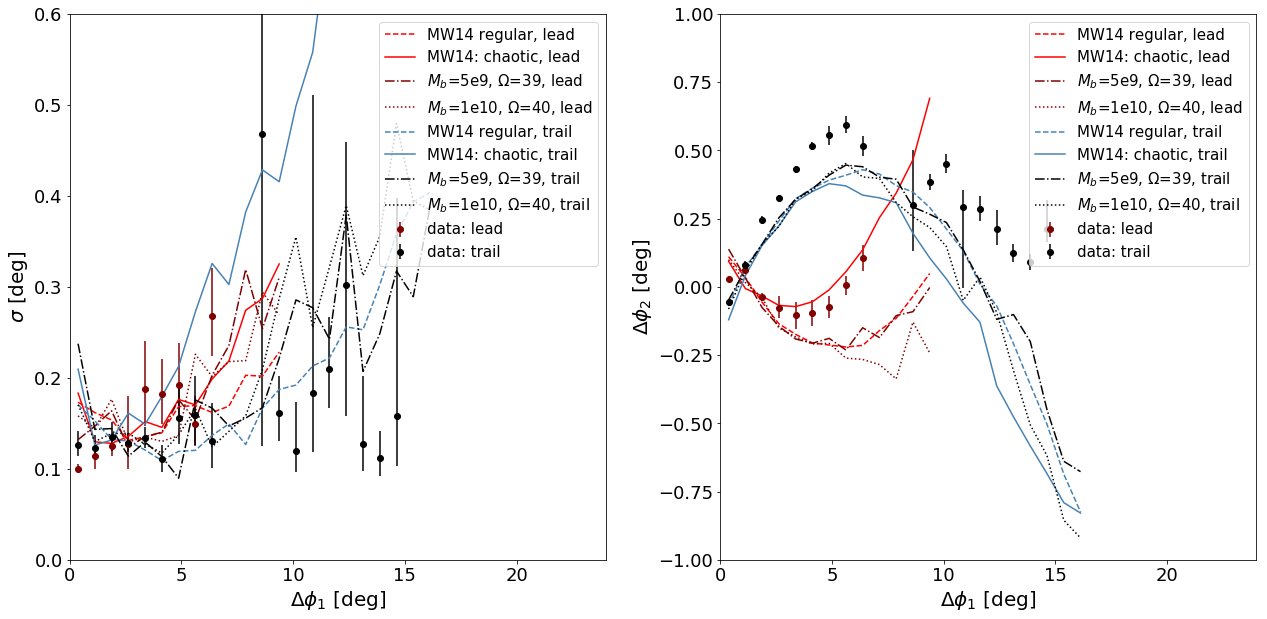

In [14]:

####Data####                                                                                                                          
lead_tbl = Table.read('../data/pal5_lead_samples.fits')
bin_mask_le = np.median(lead_tbl['a'] * lead_tbl['N'][:, None], axis=1) > 50.

trail_tbl = Table.read('../data/pal5_trail_samples.fits')
bin_mask_tr = np.median(trail_tbl['a'] * trail_tbl['N'][:, None], axis=1) > 50.

###Data                                                                                                                             
med_le = np.median(lead_tbl['std_s'], axis=1)
err1_le = med_le - np.percentile(lead_tbl['std_s'], 16, axis=1)
err2_le = np.percentile(lead_tbl['std_s'], 84, axis=1) - med_le

med_tr = np.median(trail_tbl['std_s'], axis=1)
err1_tr = med_tr - np.percentile(trail_tbl['std_s'], 16, axis=1)
err2_tr = np.percentile(trail_tbl['std_s'], 84, axis=1) - med_tr



fig,axes = plt.subplots(1, 2,figsize=(18,9), sharex=True)
for name in data.keys():
    if name=='trail':
        c = 'black'
        c1 = 'steelblue'
    else:
        c = 'maroon'
        c1= 'red'
    flatchain_reg = flatchains_reg[name]
    flatchain_chaos = flatchains_chaos[name]
    flatchain_bar5e9 = flatchains_bar5e9[name]
    flatchain_bar1e10 = flatchains_bar1e10[name]
    med_reg = np.median(flatchain_reg['std_s'], axis=1)
    med_chaos = np.median(flatchain_chaos['std_s'], axis=1)
    med_bar5e9 = np.median(flatchain_bar5e9['std_s'], axis=1)
    med_bar1e10 = np.median(flatchain_bar1e10['std_s'], axis=1)
    axes[0].plot(flatchains_reg[name]['phi1_bin_c'], med_reg, linestyle='--', label='MW14 regular, '+name, color=c1)
    axes[0].plot(flatchains_chaos[name]['phi1_bin_c'], med_chaos, linestyle='-', label='MW14: chaotic, '+name, color=c1)
    axes[0].plot(flatchains_bar5e9[name]['phi1_bin_c'], med_bar5e9, linestyle='-.', label='$M_b$=5e9, $\Omega$=39, '+name, color=c)
    axes[0].plot(flatchains_bar1e10[name]['phi1_bin_c'], med_bar1e10, linestyle=':', label='$M_b$=1e10, $\Omega$=40, '+name, color=c)

axes[0].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
                     med_le[bin_mask_le],
                     yerr=(err1_le[bin_mask_le], err2_le[bin_mask_le]),
                     marker='o', ls='none',ecolor='maroon', color='maroon',label='data: lead')

axes[0].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
                     med_tr[bin_mask_tr],
                     yerr=(err1_tr[bin_mask_tr], err2_tr[bin_mask_tr]),
                     marker='o', ls='none', ecolor='black', color='black',label='data: trail')


axes[0].set_xlim(0, 24)
axes[0].set_ylim(0, 0.6)
axes[0].set_xlabel(r'$\Delta \phi_1$ [deg]')
axes[0].set_ylabel(r'$\sigma$ [deg]')
axes[0].legend(loc='upper right', fontsize=15)
#axes[0].set_yscale('log')

med_le = np.median(lead_tbl['mu_s'], axis=1)
err1_le = med_le - np.percentile(lead_tbl['mu_s'], 16, axis=1)
err2_le = np.percentile(lead_tbl['mu_s'], 84, axis=1) - med_le

med_tr = np.median(trail_tbl['mu_s'], axis=1)
err1_tr = med_tr - np.percentile(trail_tbl['mu_s'], 16, axis=1)
err2_tr = np.percentile(trail_tbl['mu_s'], 84, axis=1) - med_tr


for name in data.keys():
    if name=='trail':
        c = 'black'
        c1 = 'steelblue'
    else:
        c = 'maroon'
        c1 = 'red'
    flatchain_reg = flatchains_reg[name]
    flatchain_chaos = flatchains_chaos[name]
    flatchain_bar5e9 = flatchains_bar5e9[name]
    flatchain_bar1e10 = flatchains_bar1e10[name]
    med_reg = np.median(flatchain_reg['mu_s'], axis=1)
    med_chaos = np.median(flatchain_chaos['mu_s'], axis=1)
    med_bar5e9 = np.median(flatchain_bar5e9['mu_s'], axis=1)
    med_bar1e10 = np.median(flatchain_bar1e10['mu_s'], axis=1)
    axes[1].plot(flatchain_reg['phi1_bin_c'], med_reg, linestyle='--', label='MW14 regular, '+name, color=c1)
    axes[1].plot(flatchains_chaos[name]['phi1_bin_c'], med_chaos, linestyle='-', label='MW14: chaotic, '+name, color=c1)
    axes[1].plot(flatchains_bar5e9[name]['phi1_bin_c'], med_bar5e9, linestyle='-.', label='$M_b$=5e9, $\Omega$=39, '+name, color=c)
    axes[1].plot(flatchains_bar1e10[name]['phi1_bin_c'], med_bar1e10, linestyle=':', label='$M_b$=1e10, $\Omega$=40, '+name, color=c)


axes[1].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
             med_le[bin_mask_le],
             yerr=(err1_le[bin_mask_le], err2_le[bin_mask_le]),
             marker='o', ls='none',ecolor='maroon', color='maroon',label='data: lead')

axes[1].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
            med_tr[bin_mask_tr],
            yerr=(err1_tr[bin_mask_tr], err2_tr[bin_mask_tr]),
            marker='o', ls='none', ecolor='black', color='black',label='data: trail')


axes[1].set_xlim(0, 24)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel(r'$\Delta \phi_1$ [deg]')
axes[1].set_ylabel('$\Delta \phi_2$ [deg]')
axes[1].legend(loc='upper right', fontsize=15)
#ax.set_aspect('equal')                                                                                                                 
fig.tight_layout()                                                                                                                 \

fig.savefig('Morphology/width_wiggle.pdf',dpi=400, rasterized=True)

In [15]:
xReg = flatchains_reg[name]['phi1_bin_c']
widthReg = np.median(flatchain_reg['std_s'], axis=1)
wiggleReg = np.median(flatchain_reg['mu_s'], axis=1)
dataReg = np.array([xReg ,widthReg,wiggleReg])
reg = np.savetxt('WidthTrack_Reg.txt', dataReg.T)


xchaos = flatchains_chaos[name]['phi1_bin_c']
widthchaos = np.median(flatchain_chaos['std_s'], axis=1)
wigglechaos = np.median(flatchain_chaos['mu_s'], axis=1)
datachaos = np.array([xchaos ,widthchaos,wigglechaos])
chaos = np.savetxt('WidthTrack_Chaos.txt', datachaos.T)



xbar5e9  = flatchains_bar5e9 [name]['phi1_bin_c']
widthbar5e9  = np.median(flatchain_bar5e9 ['std_s'], axis=1)
wigglebar5e9  = np.median(flatchain_bar5e9 ['mu_s'], axis=1)
databar5e9  = np.array([xbar5e9  ,widthReg,wigglebar5e9 ])
bar5e9  = np.savetxt('WidthTrack_bar5e9.txt', databar5e9.T)



xbar1e10 = flatchains_bar1e10[name]['phi1_bin_c']
widthbar1e10 = np.median(flatchain_bar1e10['std_s'], axis=1)
wigglebar1e10 = np.median(flatchain_bar1e10['mu_s'], axis=1)
databar1e10 = np.array([xbar1e10 ,widthbar1e10,wigglebar1e10])
bar1e10 = np.savetxt('WidthTrack_bar1e10.txt', databar1e10.T)


In [16]:
datachaos.T.shape

(22, 3)